<a href="https://colab.research.google.com/github/microprediction/microprediction/blob/master/The_Signal_And_The_Nate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FiveThirtyEight versus PredictIt
Ex-post Brier and likelihood for FiveThirtyEight presidential state results in the 2020 Election. 

See article at www.microprediction.com/blog

We perform both a naive comparison and one with a Longshot adjustment. 

### Nate Silver's pre-election probabilities

In [ ]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

nate = pd.read_csv('https://projects.fivethirtyeight.com/2020-general-data/presidential_state_toplines_2020.csv')
latest = nate.loc[nate['modeldate']=='11/3/2020',:]
trump = latest[['state','winstate_inc']]
nate = dict(zip(trump['state'].values,trump['winstate_inc'].values))

### PredictIt pre-election state prices
Swing states only at first ... see further down for more states. Tediously copied from PredictIt's election map. Let me know if I got anything wrong! 

In [ ]:
predictit_swing = {'Arizona':0.43,'Iowa':0.63,'Georgia':0.57,'Florida':0.58,'Minnesota':0.25,
            'New Hampshire':0.21,'Pennsylvania':0.38,'North Carolina':0.47,'Texas':0.71,
            'Michigan':0.30,'Wisconsin':0.28,'Ohio':0.68,'Alaska':0.88}




### Results
Right now we leave some states very close to 1 or 0 if they aren't called. I used Betfair prices for this. Results aren't super-sensitive to those approximations.

In [ ]:
trump_swing = {'Arizona':0,'Iowa':1,'Georgia':0.04,'Florida':1,'Minnesota':0,
            'New Hampshire':0,'Pennsylvania':0,'North Carolina':0.94,'Texas':1,
            'Michigan':0,'Wisconsin':0,'Ohio':1,'Alaska':1}

### Compute Brier scores
i.e. RMSE  of pre-post probability

In [ ]:
nate_swing = dict([(s,p) for s,p in nate.items() if s in predictit_swing])
nate_brier = [ (p-trump_swing[s])**2 for s,p in nate_swing.items() ]
predictit_brier = [ (p-trump_swing[s])**2 for s,p in predictit_swing.items() ]
math.sqrt(np.mean(nate_brier)),math.sqrt(np.mean(predictit_brier))

(0.35474296511428793, 0.3530417277581526)

Pretty close!  It is very hard for any one model to compete with a prediction market so in that sense, congrats to the FiveThirtyEight team.   

## Longshot Effect Adjustment
If you are not familiar with the LongShot effect, read the article "The Signal and the Nate" at www.microprediction.com/blog


Text(0, 0.5, 'Brier score')

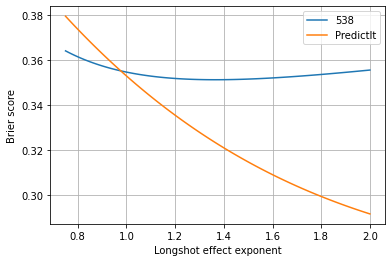

In [ ]:
def adjusted_brier(expon:float,predictions:dict,result:dict)->float:
   """ Compute Brier score after longshot adjustment  """
   adjusted = dict([(s,p**expon/(p**expon+(1-p)**expon)) for s,p in predictions.items()])
   return math.sqrt(np.mean([ (p-result[s])**2 for s,p in adjusted.items() ]))

# We choose exponents that might be vaguely realistic economically
# If I had to guess, 1.3 is probably not far off reality for betting markets
# and as it happens, that would have served FiveThirtyEight well also.  
# But the plot below shows that any choice > 1 leads to the conclusion that 
# FiveThirtyEight lost out to PredictIt this time around. 

expons =  np.linspace(0.75,2,100)
pi_briers = [ adjusted_brier(expon,predictit_swing,trump_swing) for expon in expons]
nate_briers = [ adjusted_brier(expon,nate_swing,trump_swing) for expon in expons]
plt.plot(expons,nate_briers,expons,pi_briers)
plt.grid()
plt.legend(['538','PredictIt'])
plt.xlabel('Longshot effect exponent')
plt.ylabel('Brier score')


This isn't a good picture for FiveThirtyEight. Let's see if likelihood serves them any better. 

Text(0, 0.5, 'Negative Log-Likelihood')

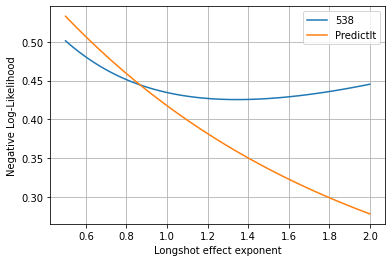

In [ ]:
import math
def adjusted_loglike(expon,predictions,result):
   fixed = dict([(s,p**expon/(p**expon+(1-p)**expon)) for s,p in predictions.items()])
   return -np.mean([ math.log(p) if result[s] else math.log(1-p) for s,p in fixed.items() ])
expons =  np.linspace(0.5,2,100)
pi_ll = [ adjusted_loglike(expon,predictit_swing,trump_swing) for expon in expons]
nate_ll = [ adjusted_loglike(expon,nate_swing,trump_swing) for expon in expons]
plt.plot(expons,nate_ll,expons,pi_ll)
plt.grid()
plt.legend(['538','PredictIt'])
plt.xlabel('Longshot effect exponent')
plt.ylabel('Negative Log-Likelihood')

No such luck. If anything the picture here is worse for FiveThirtyEight, even if you make no adjustment for LongShot. 

In [ ]:
adjusted_loglike(1,predictit_swing,trump_swing),adjusted_loglike(1,nate_swing,trump_swing)

(0.4175868026706624, 0.4345285761879868)

### So how does FiveThirtyEight lose out to PredictIt? 

In [ ]:
comparison = [ (s,t,predictit_swing[s],nate_swing[s]) for s,t in trump_swing.items()]
comparison

[('Arizona', 0, 0.43, 0.319775),
 ('Iowa', 1, 0.63, 0.6013),
 ('Georgia', 0.04, 0.57, 0.418475),
 ('Florida', 1, 0.58, 0.309),
 ('Minnesota', 0, 0.25, 0.0419),
 ('New Hampshire', 0, 0.21, 0.10915),
 ('Pennsylvania', 0, 0.38, 0.1569),
 ('North Carolina', 0.94, 0.47, 0.360675),
 ('Texas', 1, 0.71, 0.617525),
 ('Michigan', 0, 0.3, 0.053175),
 ('Wisconsin', 0, 0.28, 0.056425),
 ('Ohio', 1, 0.68, 0.546725),
 ('Alaska', 1, 0.88, 0.8505)]

So we see that against the naive interpretation of PredictIt, FiveThirtyEight picks up Brier in Arizona, Georgia, Minnessota, New Hampshire, Pennsylvania, Michigan, Wisconsin.  Loses big in Florida. Loses in Iowa, North Carolina, Texas, Ohio and Alaska. 

On the other hand...

In [ ]:
expon = 1.3
predictit_swing_adj = dict([(s,p**expon/(p**expon+(1-p)**expon)) for s,p in predictit_swing.items()])
comparison_adj = [ (s,t,predictit_swing_adj[s],nate_swing[s]) for s,t in trump_swing.items()]
comparison_adj

[('Arizona', 0, 0.40940962293076516, 0.319775),
 ('Iowa', 1, 0.6663854245742022, 0.6013),
 ('Georgia', 0.04, 0.5905903770692347, 0.418475),
 ('Florida', 1, 0.6033888240750176, 0.309),
 ('Minnesota', 0, 0.19337992781764063, 0.0419),
 ('New Hampshire', 0, 0.15156189591295302, 0.10915),
 ('Pennsylvania', 0, 0.34605790462003205, 0.1569),
 ('North Carolina', 0.94, 0.4610322831808, 0.360675),
 ('Texas', 1, 0.7620586417812818, 0.617525),
 ('Michigan', 0, 0.2494613381806368, 0.053175),
 ('Wisconsin', 0, 0.22656669309192073, 0.056425),
 ('Ohio', 1, 0.7270890370763118, 0.546725),
 ('Alaska', 1, 0.9302255517774538, 0.8505)]

We see that the unwinding the longshot effect increases the discrepancy in states like Texas and Ohio, Alaska. FiveThirtyEight can't recover from that. 

## Adding more states 

I find it problematic that FiveThirtyEight does worse in swing states. But let's add some more states in and see if it makes a difference. 

In [ ]:
predictit_more = {'California':0.06,'Washington':0.06,'Oregon':0.097,
                  'North Dakota':0.96,'South Dakota':0.97,'Nebraska':0.97,
                  'Kansas':0.96,'Virginia':0.07,'Mississippi':0.94,
                  'Louisiana':0.97,'Alabama':0.97,'West Virginia':0.96,
                  'Maryland':0.05}

trump_more = {'California':0,'Washington':0,'Oregon':0,
              'North Dakota':1,'South Dakota':1,'Nebraska':1,'Kansas':1,
              'Virginia':0,'Mississippi':1,'Louisiana':1,'Alabama':1,
              'West Virginia':1,'Maryland':0}
predictit_more.update(predictit_swing)
trump_more.update(trump_swing)
nate_more = dict([(s,p) for s,p in nate.items() if s in predictit_more])


Text(0, 0.5, 'Brier score')

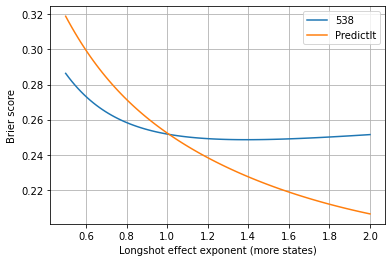

In [ ]:
# Does it make a difference??
# Short answer is no, and including more states makes it harder to improve the 538 model. 

expons =  np.linspace(0.5,2,100)
pi_briers = [ adjusted_brier(expon,predictit_more,trump_more) for expon in expons]
nate_briers = [ adjusted_brier(expon,nate_more,trump_more) for expon in expons]
import matplotlib.pyplot as plt
plt.plot(expons,nate_briers,expons,pi_briers)
plt.grid()
plt.legend(['538','PredictIt'])
plt.xlabel('Longshot effect exponent (more states)')
plt.ylabel('Brier score')

"not really". Add more states as you see fit, but be mindful of the 5% charge for withdrawals and 10% charge for winnings. 

In [1]:
# Quick look at some alt data but here the prob model isn't calibrated
cpolls = [0.591,0.540,0.498,0.586,0.372,0.467,0.434,0.443,0.529,0.504,0.365,0.605,0.432,0.554,0.521,0.562,0.597,0.559,0.474,0.387,0.376,0.486,0.480,0.552,0.573,0.561,0.579,0.476,0.484,0.433,0.455,0.401,0.499,0.619,0.539,0.622,0.444,0.518,0.427,0.522,0.597,0.583,0.525,0.552,0.386,0.465,0.443,0.642,0.473,0.659]
a = 2
cprobs = [ math.exp(a*p)/(math.exp(a*(1-p))+math.exp(a*p)) for p in cpolls ]
states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois","Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana","Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York","North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania","Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah","Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]
cascend = dict(zip(states,probs))
cascend_more = dict([(k,v) for k,v in cascend.items() if k in trump_more])
cascend_briers = [ adjusted_brier(expon,cascend_more,trump_more) for expon in expons]
nate_briers = [ adjusted_brier(expon,nate_more,trump_more) for expon in expons]
sum(cascend_briers),sum(nate_briers)

NameError: ignored

In [ ]:
len(cascend_briers), len(nate_briers)

(100, 100)

Text(0, 0.5, 'Brier score')

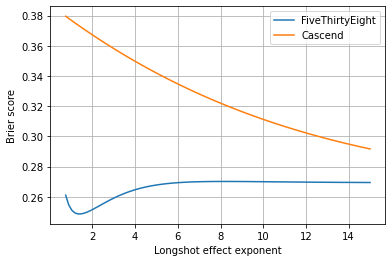

In [ ]:

expons =  np.linspace(0.75,15,100)
cascend_briers = [ adjusted_brier(expon,cascend_more,trump_more) for expon in expons]
nate_briers = [ adjusted_brier(expon,nate_more,trump_more) for expon in expons]
plt.plot(expons,nate_briers,expons,pi_briers)
plt.grid()
plt.legend(['FiveThirtyEight','Cascend'])
plt.xlabel('Longshot effect exponent')
plt.ylabel('Brier score')
